#### Imports

In [833]:
import pandas as pd
import datetime
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [834]:
pd.options.mode.chained_assignment = None  # default='warn'

#### Load Data

In [835]:
PATH = 'data/'

In [836]:
transaction = pd.read_csv(PATH + 'transaction.csv', parse_dates=['transaction_date','product_first_sold_date'])
demograhic = pd.read_csv(PATH + 'customer_demographic.csv', parse_dates=['DOB'])
address = pd.read_csv(PATH + 'customer_address.csv')

In [837]:
# list of customers of whom we will filter out to target
new_customer = pd.read_csv(PATH + 'new_customers.csv', parse_dates=['DOB'])

In [838]:
merged_data = pd.merge(transaction, demograhic, on='customer_id', suffixes=('trans_', 'demo_'), how='inner')
df = pd.merge(merged_data, address, on='customer_id', how='inner')


In [839]:
df.head()

,Unnamed: 0trans_,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,...,default,owns_car,tenure,age,Unnamed: 0,address,postcode,state,country,property_valuation
0,0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,...,ã»(ï¿£âï¿£)ã»:*:,Yes,10.0,68.0,2945,984 Hoepker Court,3064,VIC,Australia,6
1,11064,11065,1,2950,2017-10-16,0.0,Approved,Giant Bicycles,Standard,medium,...,ã»(ï¿£âï¿£)ã»:*:,Yes,10.0,68.0,2945,984 Hoepker Court,3064,VIC,Australia,6
2,18922,18923,62,2950,2017-04-26,0.0,Approved,Solex,Standard,medium,...,ã»(ï¿£âï¿£)ã»:*:,Yes,10.0,68.0,2945,984 Hoepker Court,3064,VIC,Australia,6
3,1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,...,ZÌ®ÌÍÌ ÍÍAÌ¥ÌÌÍÌ»ÌLÌ£ÍÍÌ¯Ì¹ÌÍGÌ»OÌ­ÌÌ®,Yes,10.0,44.0,3115,4 Shopko Circle,2196,NSW,Australia,5
4,6861,6862,4,3120,2017-10-05,0.0,Approved,Giant Bicycles,Standard,high,...,ZÌ®ÌÍÌ ÍÍAÌ¥ÌÌÍÌ»ÌLÌ£ÍÍÌ¯Ì¹ÌÍGÌ»OÌ­ÌÌ®,Yes,10.0,44.0,3115,4 Shopko Circle,2196,NSW,Australia,5


In [840]:
df.shape    

(19968, 35)

In [841]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19968 entries, 0 to 19967
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Unnamed: 0trans_                     19968 non-null  int64         
 1   transaction_id                       19968 non-null  int64         
 2   product_id                           19968 non-null  int64         
 3   customer_id                          19968 non-null  int64         
 4   transaction_date                     19968 non-null  datetime64[ns]
 5   online_order                         19609 non-null  float64       
 6   order_status                         19968 non-null  object        
 7   brand                                19773 non-null  object        
 8   product_line                         19773 non-null  object        
 9   product_class                        19773 non-null  object        
 10  product_si

In [842]:
unique_users = df['customer_id'].unique()
print('Number of unique users: ', len(unique_users))

Number of unique users:  3489


In [843]:
# remove deceased customers
df = df[df['deceased_indicator'] == 'No']

In [844]:
df.shape

(19960, 35)

#### Demographics: 

##### Age Distribution

In [845]:
df.age.describe()

count    19514.000000
mean        45.914062
std         12.922907
min         21.000000
25%         36.000000
50%         46.000000
75%         55.000000
max        180.000000
Name: age, dtype: float64

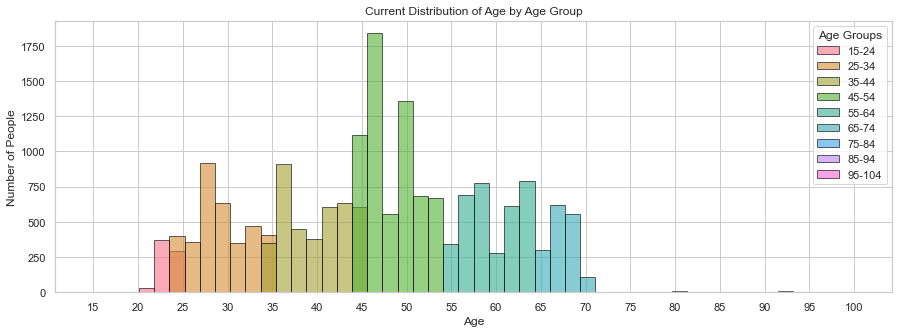

In [846]:
# Define age groups and color palette
age_groups = [(15, 24), (25, 34), (35, 44), (45, 54), (55, 64), (65, 74), (75, 84), (85, 94), (95, 104)]
colors = sns.color_palette("husl", len(age_groups))
plt.figure(figsize=(15,5))

# Loop through age groups, plot histograms, and create legends
for age_range, color in zip(age_groups, colors):
    mask = (df.age >= age_range[0]) & (df.age <= age_range[1])
    df.loc[mask, 'age'].hist(alpha=0.6, bins=50, range=(15,100), color=color, edgecolor='black', label=f"{age_range[0]}-{age_range[1]}")

plt.xticks(range(15, 101, 5))
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.title('Current Distribution of Age by Age Group')
plt.legend(title='Age Groups')
plt.show()


Potential age outliers:


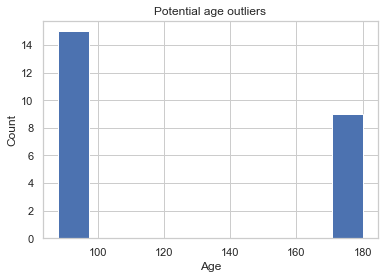

In [847]:
#  age outlier 
q1 = df['age'].quantile(0.25)
q3 = df['age'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

age_outlier = df[(df['age'] < lower_bound) | (df['age'] > upper_bound)]
print('Potential age outliers:')

# plot
age_outlier.age.hist()
plt.title('Potential age outliers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

##### Gender Distribution
Analyze the proportion of male, female, and other gender customers.


In [848]:
# exploring gender
gender_ratio = df.groupby('gender').agg({'customer_id':'count'}).reset_index()
gender_ratio = gender_ratio.rename(columns={'customer_id':'count'})
gender_ratio


,gender,count
0,Female,9989
1,Male,9516
2,Undefined,455


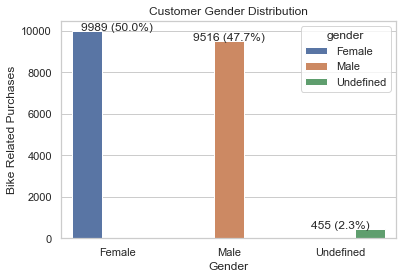

In [849]:
# Calculate gender ratio and percentages in respect to bike related purchases
gender_ratio = df.groupby('gender').agg({'transaction_id': 'nunique'}).reset_index()
gender_ratio = gender_ratio.rename(columns={'transaction_id': 'count'})
gender_ratio['percentage'] = gender_ratio['count'] / gender_ratio['count'].sum() * 100

# Plot the bar chart
p = sns.barplot(x='gender', y='count', hue='gender', data=gender_ratio)
plt.title('Customer Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Bike Related Purchases')

# Add count and percentage labels
for i, row in gender_ratio.iterrows():
    p.text(i, row['count'] + 10, f"{row['count']} ({row['percentage']:.1f}%)", ha='center', fontsize=12)

plt.show()


##### Geographic Distribution
Determine where your customers are located based on the 'state', 'country', and 'postcode' columns.


In [850]:
# state 
state_ratio = df.groupby('state').agg({'customer_id':'nunique'}).reset_index()
state_ratio = state_ratio.rename(columns={'customer_id':'count'})

state_ratio

,state,count
0,NSW,1865
1,QLD,743
2,VIC,880


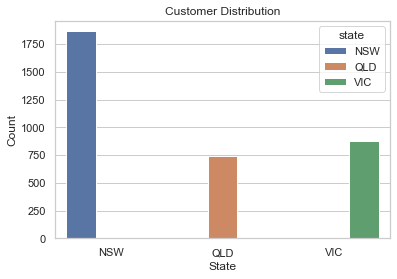

In [851]:
p = sns.barplot(x='state', y='count', hue='state', data=state_ratio)
plt.title('Customer Distribution')
plt.xlabel('State')
plt.ylabel('Count')
plt.show()

In [852]:
# drilling down into female and males in each state 
gender_state_ratio = df.groupby(by=['state','gender']).agg({'customer_id':'count'}).reset_index()
gender_state_ratio.rename(columns={'customer_id':'count'}, inplace=True)
gender_state_ratio

,state,gender,count
0,NSW,Female,5392
1,NSW,Male,5045
2,NSW,Undefined,240
3,QLD,Female,2087
4,QLD,Male,2086
5,QLD,Undefined,89
6,VIC,Female,2510
7,VIC,Male,2385
8,VIC,Undefined,126


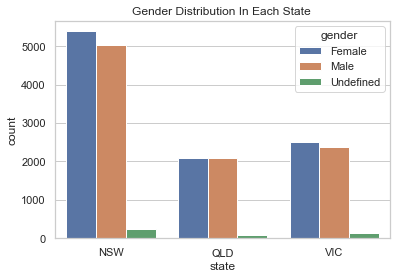

In [853]:
sns.barplot(x='state',y='count', data = gender_state_ratio, hue='gender')
plt.title('Gender Distribution In Each State ')
plt.show()

In [854]:
# drilling down into most prominant age groups in each state
age_state_ratio = df.groupby(by=['state','age']).agg({'customer_id':'count'}).reset_index()
age_state_ratio.rename(columns={'customer_id':'count'}, inplace=True)

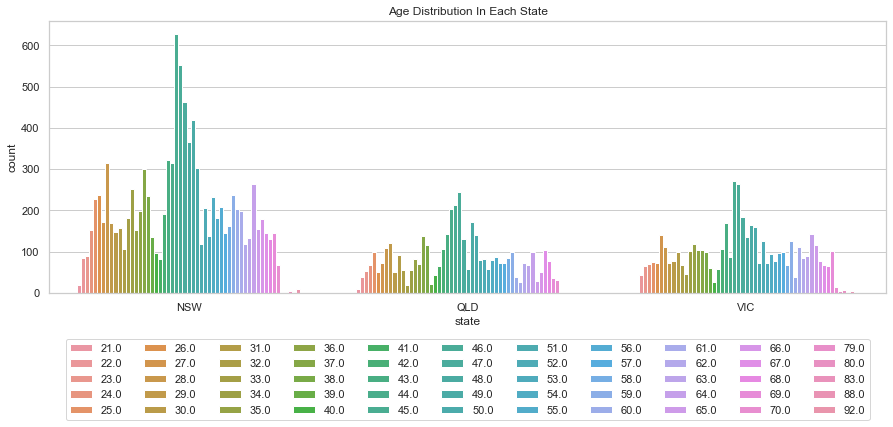

In [855]:
# plot age distribution in each state
age_state_ratio = age_state_ratio[age_state_ratio['age'] < 100]


plt.figure(figsize=(15,5))
sns.barplot(x='state',y='count', data=age_state_ratio, hue='age')
plt.title('Age Distribution In Each State')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=11)
plt.show()


In [856]:
# postcode 
postcode_data = df[['postcode']]

# The scaler transforms the features by subtracting the mean and dividing by the standard deviation. 
# This is done in order to standardize the scale of each feature and bring them to the same level of importance.
scaler = StandardScaler()
postcode_data_scaled = scaler.fit_transform(postcode_data)

# cluster data
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(postcode_data_scaled)

# add cluster labels to dataframe
df['postcode_cluster'] = kmeans.labels_

Summary :
     postcode_cluster   min   max
0                 0  2000  2400
1                 1  3610  4306
2                 2  3000  3585
3                 3  2428  2880
4                 4  4340  4883 



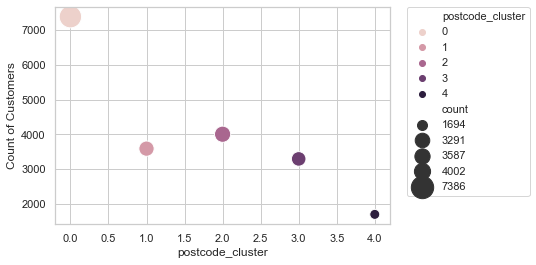

In [857]:
# plot
most_customers_loc = df.groupby('postcode_cluster').agg({'customer_id':'count'}).reset_index()
most_customers_loc.rename(columns={'customer_id':'count'}, inplace=True)

ax = sns.scatterplot(x='postcode_cluster', y='count', data=most_customers_loc, size='count', sizes=(100, 500), hue='postcode_cluster')
ax.set_ylabel('Count of Customers')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Group the DataFrame by 'postcode_cluster' and find the min and max postal code for each cluster
postcode_ranges = df.groupby('postcode_cluster')['postcode'].agg(['min', 'max']).reset_index()
print('Summary :\n ' ,postcode_ranges.head(), '\n') 

In [858]:
# property_valuation
property_valuation = df.groupby('property_valuation').agg({'customer_id':'nunique'}).reset_index()
property_valuation.rename(columns={'customer_id':'count'}, inplace=True)

print("Statistics:\n" , df['property_valuation'].describe())

Statistics:
 count    19960.000000
mean         7.518186
std          2.823901
min          1.000000
25%          6.000000
50%          8.000000
75%         10.000000
max         12.000000
Name: property_valuation, dtype: float64


Text(0.5, 1.0, 'Distribution of Property Evaluation')

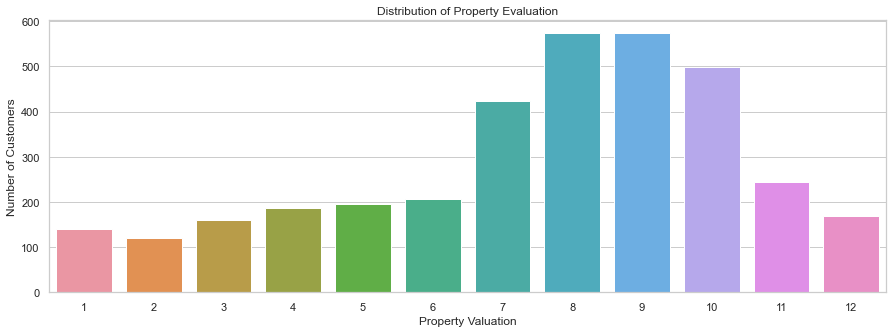

In [859]:
# property valuation
plt.figure(figsize=(15,5))
sns.barplot(x='property_valuation', y='count', data=property_valuation)
plt.xlabel('Property Valuation')
plt.ylabel('Number of Customers')
plt.title('Distribution of Property Evaluation')

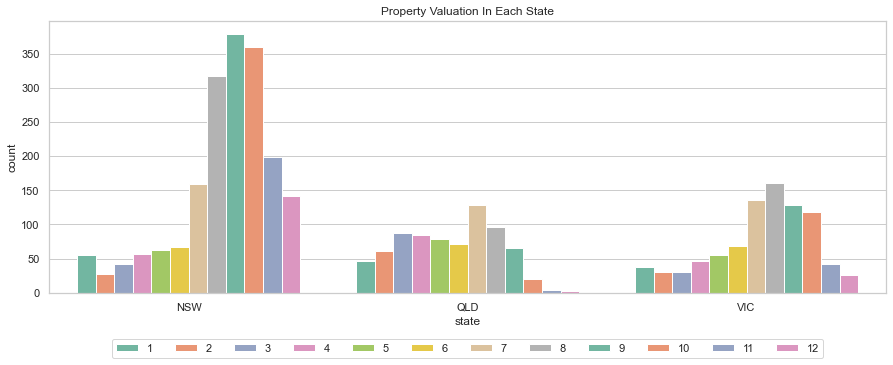

In [860]:
# zooming in on the most common property valuation in each state 
property_valuation_state = df.groupby(by=['state','property_valuation']).agg({'customer_id':'nunique'}).reset_index()
property_valuation_state.rename(columns={'customer_id':'count'}, inplace=True)

# plot  
plt.figure(figsize=(15,5))
sns.barplot(x='state',y='count', data=property_valuation_state, hue='property_valuation', palette='Set2')
plt.title('Property Valuation In Each State')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=14)
plt.show()

In [861]:
# zooming in the most common property valuation for each gender
property_valuation_gender = df.groupby(by=['gender','property_valuation']).agg({'customer_id':'nunique'}).reset_index()
property_valuation_gender.rename(columns={'customer_id':'count'}, inplace=True)

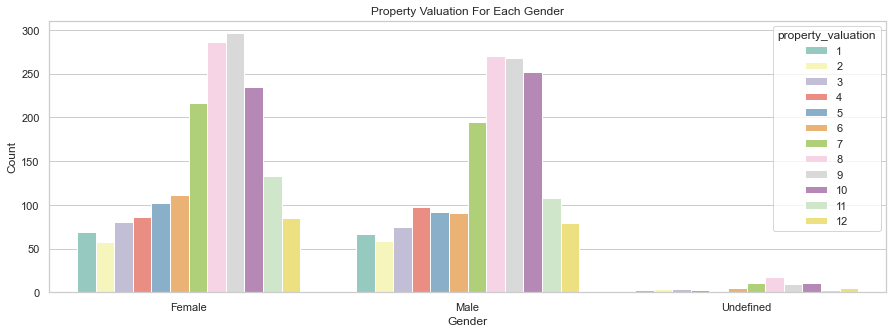

In [862]:
# plot 
plt.figure(figsize=(15,5))
sns.barplot(x='gender', y='count', data = property_valuation_gender, hue='property_valuation', palette='Set3')
plt.title('Property Valuation For Each Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

#### Purchase Behavior

##### Purchase Frequency

In [863]:
# Calculate purchase frequency
total_transactions = df['transaction_id'].nunique()
total_customers = df['customer_id'].nunique()

# Average number of transactions per customer
purchase_frequency = total_transactions / total_customers
print(f"Purchase Frequency: {purchase_frequency:.2f} transactions per customer")


Purchase Frequency: 5.72 transactions per customer


##### Average Purchase Value

In [864]:
# total revenue 
total_revenue = df['list_price'].sum()

# average purchase value  
avg_purchase_value = total_revenue / total_transactions

print(f"Average Purchase Value: ${avg_purchase_value:.2f}")


Average Purchase Value: $1107.63


##### Average Profit Per Transaction

In [865]:
# total profit 
total_profit = df['profit'].sum()

# average profit per transaction
avg_profit = total_profit / total_transactions

print(f"Average Profit Per Transaction: ${avg_profit:.2f}")

Average Profit Per Transaction: $546.39


##### Online vs. Offline Orders

In [866]:
df['online_order'].value_counts(normalize=True)

1.0    0.500689
0.0    0.499311
Name: online_order, dtype: float64

##### RFM - Recency, Frequency, and Monetary value
RFM is a marketing analysis technique used to segment customers based on their purchasing behavior

1. Recency: This value represents the time elapsed since the customer's last purchase. Customers who have purchased more recently are considered more likely to make future purchases. Recency is often measured in days or months.
2. Frequency: This value represents the total number of purchases made by a customer. A higher frequency indicates that the customer is more engaged and more likely to make future purchases.
3. Monetary value: This value represents the total amount of money a customer has spent with the company. Customers who have spent more money are considered more valuable, as they contribute more revenue to the business.

In [867]:

# Calculate the Monetary value for each customer
monetary_value = df.groupby('customer_id')['profit'].sum()

# Calculate the Frequency for each customer
frequency = df.groupby('customer_id')['transaction_id'].count()

# Calculate the Recency for each customer (this is supposed ot be at the date of extraction but we will use the last date in the dataset)
snapshot_date = df['transaction_date'].max()
recency = df.groupby('customer_id')['transaction_date'].max()
recency = (snapshot_date - recency).dt.days

# Create a new DataFrame to store the RFM values for each customer
rfm = pd.DataFrame({'Recency': recency, 'Frequency': frequency, 'MonetaryValue': monetary_value})

print(rfm.head())

             Recency  Frequency  MonetaryValue
customer_id                                   
1                  7         11        3018.09
2                128          3        2226.26
4                195          2         220.57
5                 16          6        2394.94
6                 64          5        3946.55


In [868]:
# Assign quartiles for Recency, Frequency, and Monetary Value, 4 is considered a high value
rfm['R_quartile'] = pd.qcut(rfm['Recency'], 4, labels=list(range(4, 0, -1)))
rfm['F_quartile'] = pd.qcut(rfm['Frequency'], 4, labels=list(range(1, 5)))
rfm['M_quartile'] = pd.qcut(rfm['MonetaryValue'], 4, labels=list(range(1, 5)))

# Combine RFM quartile values to create a composite RFM score
rfm['RFM_score'] = rfm['R_quartile'].astype(str) + rfm['F_quartile'].astype(str) + rfm['M_quartile'].astype(str)

# Segment customers based on their RFM scores
def rfm_segment(row):
    if row['R_quartile'] >= 3 and row['F_quartile'] >= 3 and row['M_quartile'] >= 3:
        return 'High Value'
    elif row['R_quartile'] >= 2 and row['F_quartile'] >= 2:
        return 'Mid Value'
    else:
        return 'Low Value'

rfm['RFM_segment'] = rfm.apply(rfm_segment, axis=1)

# Display the segmented customers with their RFM scores
print(rfm.head())


             Recency  Frequency  MonetaryValue R_quartile F_quartile  \
customer_id                                                            
1                  7         11        3018.09          4          4   
2                128          3        2226.26          1          1   
4                195          2         220.57          1          1   
5                 16          6        2394.94          4          2   
6                 64          5        3946.55          2          2   

            M_quartile RFM_score RFM_segment  
customer_id                                   
1                    3       443  High Value  
2                    2       112   Low Value  
4                    1       111   Low Value  
5                    2       422   Mid Value  
6                    3       223   Mid Value  


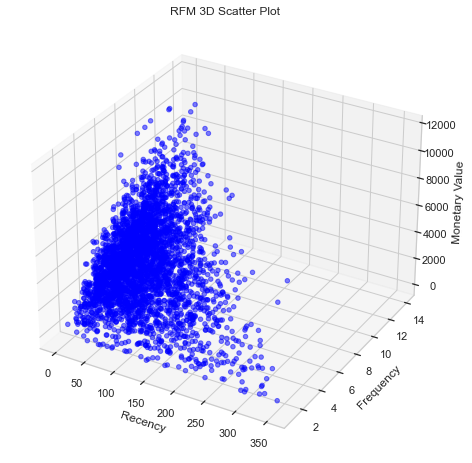

In [869]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['MonetaryValue'], c='blue', marker='o', alpha=0.5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value')

plt.title('RFM 3D Scatter Plot')
plt.show()


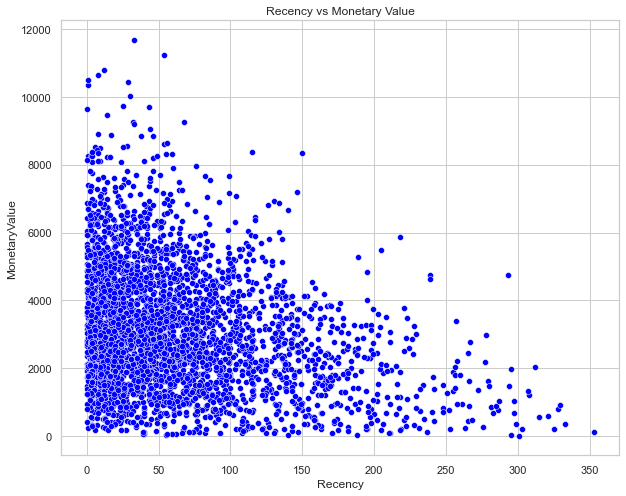

In [870]:
fig = plt.figure(figsize=(10, 8))

sns.scatterplot(data = rfm, x = rfm['Recency'], y = rfm['MonetaryValue'], color='Blue')

ax.set_xlabel('Recency')
ax.set_ylabel('Monetary Value')

plt.title('Recency vs Monetary Value')
plt.show()


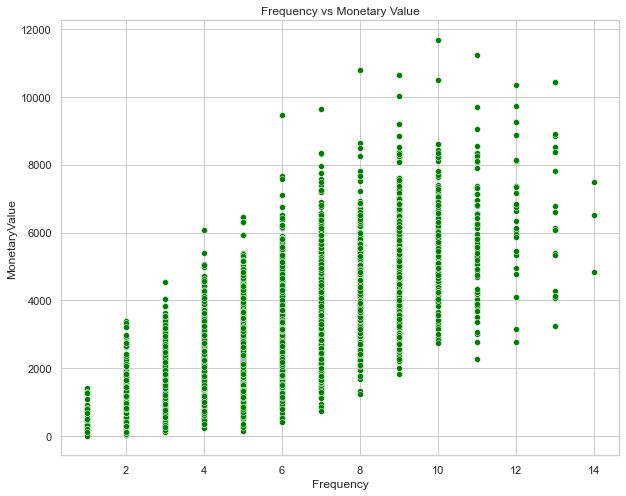

In [871]:
fig = plt.figure(figsize=(10, 8))

sns.scatterplot(data = rfm, x = rfm['Frequency'], y = rfm['MonetaryValue'], color='Green')

ax.set_xlabel('Recency')
ax.set_ylabel('Monetary Value')

plt.title('Frequency vs Monetary Value')
plt.show()


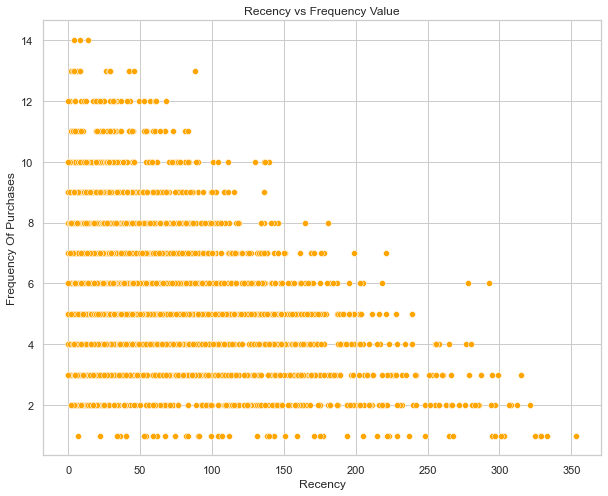

In [872]:
fig = plt.figure(figsize=(10, 8))

sns.scatterplot(data = rfm, x = rfm['Recency'], y = rfm['Frequency'], color='Orange')

plt.xlabel('Recency')
plt.ylabel('Frequency Of Purchases')

plt.title('Recency vs Frequency Value')
plt.show()


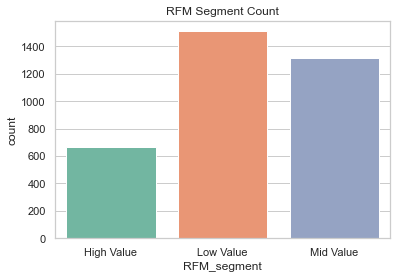

In [873]:
rfm_count = rfm.groupby('RFM_segment').agg({'RFM_score':'count'}).reset_index()
rfm_count.rename(columns={'RFM_score':'count'}, inplace=True)

sns.barplot(x='RFM_segment', y='count', data=rfm_count, palette='Set2')
plt.title('RFM Segment Count')
plt.show()

#### RFM Segmentation

In [874]:
# convert fields to int
rfm['Recency'] = rfm.Recency.astype(int)
rfm['Frequency'] = rfm.Frequency.astype(int)
rfm['MonetaryValue'] = rfm.MonetaryValue.astype(int)
rfm['R_quartile'] = rfm.R_quartile.astype(int)
rfm['F_quartile'] = rfm.F_quartile.astype(int)
rfm['M_quartile'] = rfm.M_quartile.astype(int)
rfm['RFM_score'] = rfm.RFM_score.astype(int)

In [875]:
def categorize_customer(df):
    # rfm_score = 141
    rfm_score = df['RFM_score']

    if rfm_score == 444 :
        return 'Platinum Customer'
    elif  443 >= rfm_score > 433 :
        return 'Very Loyal'
    elif 433 >= rfm_score > 421 :
        return 'Becoming Loyal'
    elif 421 >= rfm_score > 344 :
        return 'Recent Customer'
    elif 344 >= rfm_score > 323 :
        return 'Potential Customer'
    elif 323 >= rfm_score > 311 :
        return 'Late Bloomer'
    elif 311 >= rfm_score > 224 :
        return 'Losing Customer'
    elif 224 >= rfm_score > 212 :
        return 'High Risk Customer'
    elif 212 >= rfm_score > 124 :
        return 'Almost Lost Customer'
    elif 124 >= rfm_score >= 112 :
        return 'Evasive Customer'
    elif rfm_score <= 111:
        return 'Lost Customer'
    else:
        return 'Uncategorized'

rfm['customer_category'] =  rfm.apply(categorize_customer, axis=1)

In [876]:
rfm_groups = rfm.groupby('customer_category').agg({'F_quartile':'min','R_quartile':'min','M_quartile':'min'}).reset_index()
rfm_groups.head()

,customer_category,F_quartile,R_quartile,M_quartile
0,Almost Lost Customer,1,1,1
1,Becoming Loyal,2,4,1
2,Evasive Customer,1,1,1
3,High Risk Customer,1,2,1
4,Late Bloomer,1,3,1


In [877]:
rfm_groups[rfm_groups['customer_category'] == 'Uncategorized']

,customer_category,F_quartile,R_quartile,M_quartile


In [878]:
df_melted = pd.melt(rfm_groups, id_vars=['customer_category'], var_name='quartile', value_name='value')

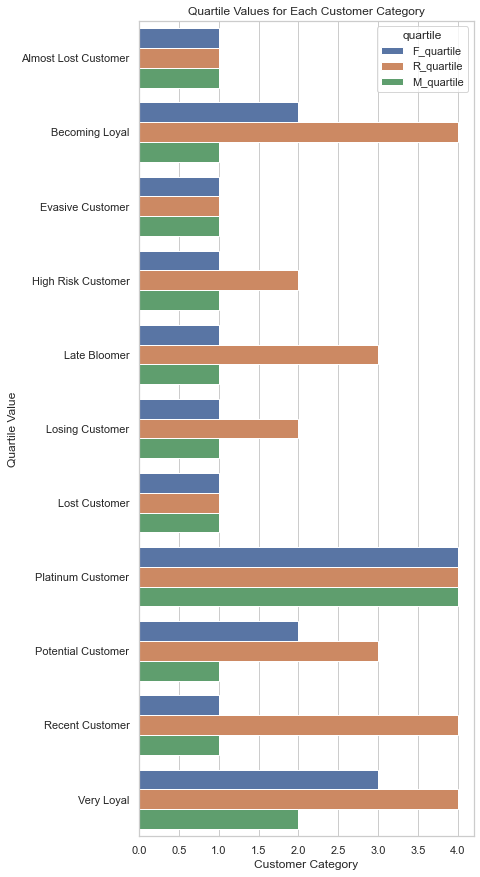

In [879]:
sns.set(style="whitegrid")
plt.figure(figsize=(6,15))

# Create a bar plot with hue for the quartile columns
bar_plot = sns.barplot(data=df_melted, y='customer_category', x='value', hue='quartile', dodge=True)

# Set axis labels and title
bar_plot.set(xlabel='Customer Category', ylabel='Quartile Value')
plt.title('Quartile Values for Each Customer Category')

# Display the plot
plt.show()

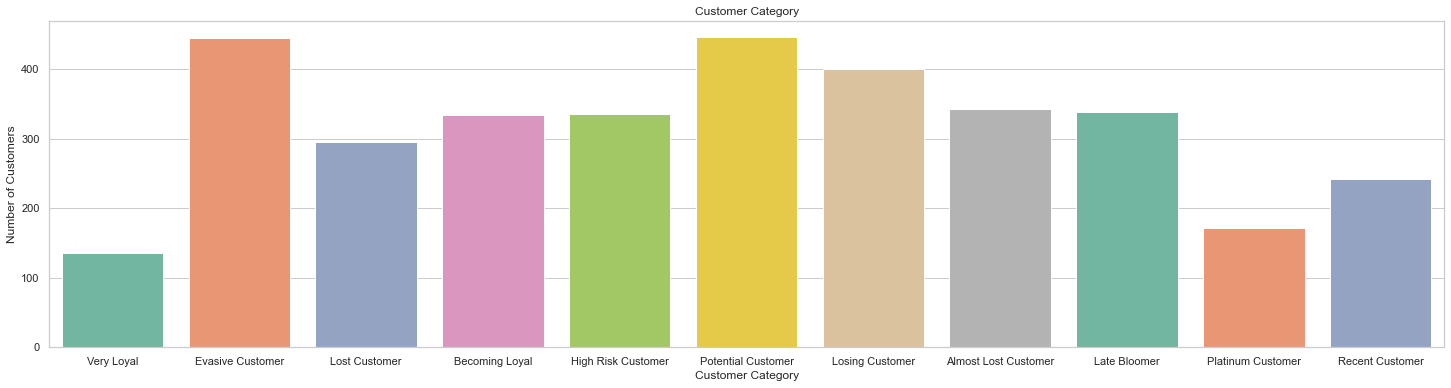

In [880]:
plt.figure(figsize=(25,6))
ax = sns.countplot(x='customer_category', data=rfm, palette='Set2')

plt.title('Customer Category')
plt.xlabel('Customer Category')
plt.ylabel('Number of Customers')             
plt.show()

In [881]:
# to csv
rfm_groups.to_csv(PATH + 'rfm_groups.csv', index=False)
rfm.reset_index().to_csv(PATH + 'rfm.csv', index=False)

#### Product Preferences

##### Overview 

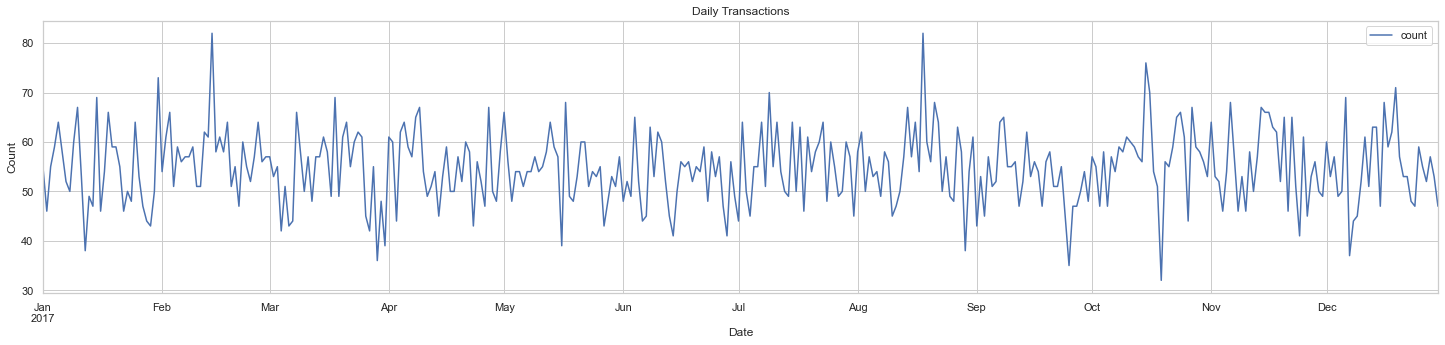

In [882]:
# transaction behaviour
daily_trans = df.groupby('transaction_date').agg({'transaction_id':'count'}).reset_index()
daily_trans = daily_trans.rename(columns = {'transaction_id':'count'})

daily_trans.plot(x='transaction_date', y='count', figsize=(25, 5))
plt.title('Daily Transactions')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

##### Top-selling brands

Top-selling brands by revenue:
 brand
Solex             4489300.64
WeareA2B          4151241.75
Giant Bicycles    4087286.32
Trek Bicycles     3529152.49
OHM Cycles        2987703.02
Norco Bicycles    2652726.13
Name: list_price, dtype: float64


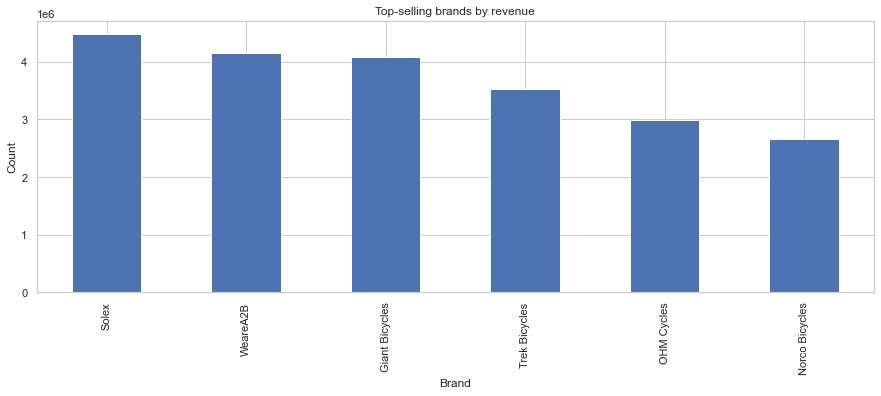

In [883]:
# Top-selling brands by revenue
brand_revenue = df.groupby('brand')['list_price'].sum().sort_values(ascending=False)
print("Top-selling brands by revenue:\n", brand_revenue)

plt.figure(figsize=(15,5))
brand_revenue.plot(kind='bar')
plt.title('Top-selling brands by revenue')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show()


Top-selling brands by quantity:
 Solex             4246
Giant Bicycles    3308
WeareA2B          3288
OHM Cycles        3037
Trek Bicycles     2982
Norco Bicycles    2904
Name: brand, dtype: int64


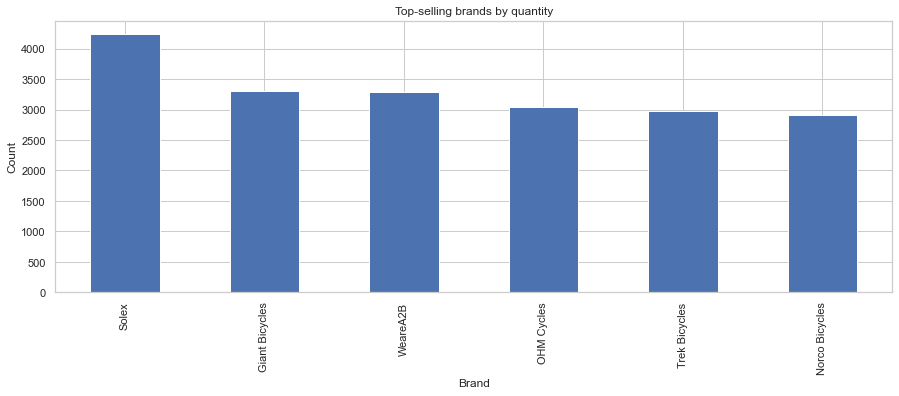

In [884]:
# Top-selling brands by quantity
brand_quantity = df['brand'].value_counts().sort_values(ascending=False)
print("\nTop-selling brands by quantity:\n", brand_quantity)


plt.figure(figsize=(15,5))
brand_quantity.plot(kind='bar')
plt.title('Top-selling brands by quantity')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show()

##### Popular Product Lines, Classes, & Sizes

In [885]:
# Most popular product lines
product_line_popularity = df['product_line'].value_counts(normalize=True).sort_values(ascending=False)
print("\nMost popular product lines:\n", product_line_popularity)


Most popular product lines:
 Standard    0.715963
Road        0.200455
Touring     0.062332
Mountain    0.021250
Name: product_line, dtype: float64


In [886]:

# Most popular product classes
product_class_popularity = df['product_class'].value_counts(normalize=True).sort_values(ascending=False)
print("\nMost popular product classes:\n", product_class_popularity)


Most popular product classes:
 medium    0.697951
high      0.152391
low       0.149658
Name: product_class, dtype: float64


In [887]:
# Most popular product sizes
product_size_popularity = df['product_size'].value_counts(normalize=True).sort_values(ascending=False)
print("\nMost popular product sizes:\n", product_size_popularity)


Most popular product sizes:
 medium    0.655856
large     0.200810
small     0.143334
Name: product_size, dtype: float64


##### Bike-Related Purchases

In [888]:
bike_purchases_stats = df['past_3_years_bike_related_purchases'].describe()
print("Bike-related purchases statistics:\n", bike_purchases_stats)

Bike-related purchases statistics:
 count    19960.000000
mean        48.744088
std         28.609349
min          0.000000
25%         24.000000
50%         48.000000
75%         73.000000
max         99.000000
Name: past_3_years_bike_related_purchases, dtype: float64


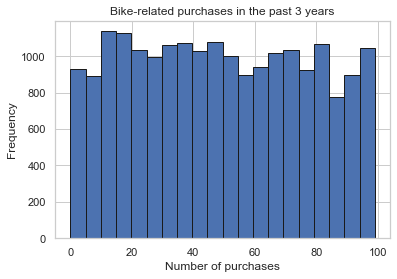

In [889]:
# Create a histogram for the past_3_years_bike_related_purchases column
plt.hist(df['past_3_years_bike_related_purchases'], bins=20, edgecolor='k')
plt.title("Bike-related purchases in the past 3 years")
plt.xlabel("Number of purchases")
plt.ylabel("Frequency")
plt.show()


In [890]:
# Calculate the top 10 customers with the highest number of bike-related purchases
top_customers = df.nlargest(10, 'past_3_years_bike_related_purchases')[['customer_id', 'past_3_years_bike_related_purchases']]
print("\nTop 10 customers with the highest number of bike-related purchases:\n", top_customers)


Top 10 customers with the highest number of bike-related purchases:
      customer_id  past_3_years_bike_related_purchases
498         2884                                   99
499         2884                                   99
500         2884                                   99
501         2884                                   99
502         2884                                   99
503         2884                                   99
504         2884                                   99
505         2884                                   99
844         1282                                   99
845         1282                                   99


In [891]:
# looking at the transaction date range 
df['transaction_date'].min(), df['transaction_date'].max() #spans 12 months 

(Timestamp('2017-01-01 00:00:00'), Timestamp('2017-12-30 00:00:00'))

##### Customer Segmentation

#### Wealth segments

In [892]:
wealth_segment = df.groupby('wealth_segment').agg({'customer_id':'count'}).reset_index()
wealth_segment.rename(columns={'customer_id':'count'}, inplace=True)
wealth_segment.sort_values(by='count', ascending=False, inplace=True)
wealth_segment

,wealth_segment,count
2,Mass Customer,10029
1,High Net Worth,5081
0,Affluent Customer,4850


In [893]:
# zooming in at the most common wealth segment in each state
wealth_segment_state = df.groupby(by=['state','wealth_segment']).agg({'customer_id':'count'}).reset_index()
wealth_segment_state.rename(columns={'customer_id':'count'}, inplace=True)
wealth_segment_state

,state,wealth_segment,count
0,NSW,Affluent Customer,2577
1,NSW,High Net Worth,2760
2,NSW,Mass Customer,5340
3,QLD,Affluent Customer,1048
4,QLD,High Net Worth,1081
5,QLD,Mass Customer,2133
6,VIC,Affluent Customer,1225
7,VIC,High Net Worth,1240
8,VIC,Mass Customer,2556


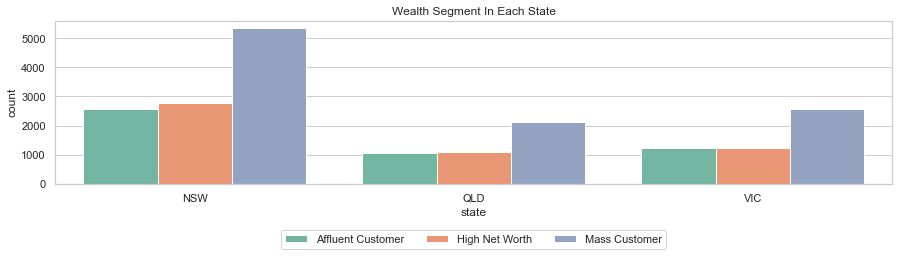

In [894]:
# plot
plt.figure(figsize=(15,3))
sns.barplot(x='state', y='count', data=wealth_segment_state, hue='wealth_segment', palette='Set2')
plt.title('Wealth Segment In Each State')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=14)
plt.show()

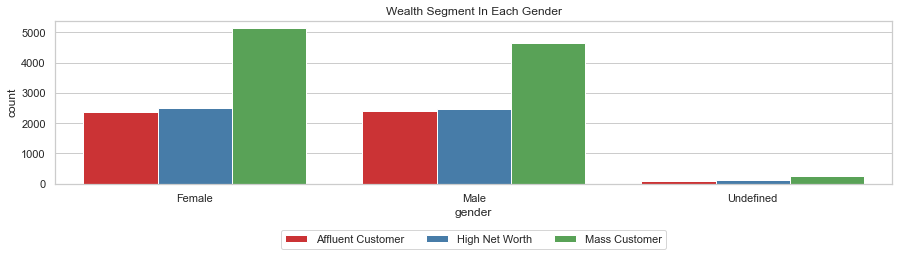

In [895]:
# zooming in at the most common wealth segment for each gender 
wealth_segment_gender = df.groupby(by=['gender','wealth_segment']).agg({'customer_id':'count'}).reset_index()
wealth_segment_gender.rename(columns={'customer_id':'count'}, inplace=True)

# plot
plt.figure(figsize=(15,3))
sns.barplot(x='gender', y='count', data=wealth_segment_gender, hue='wealth_segment', palette='Set1')
plt.title('Wealth Segment In Each Gender')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=14)
plt.show()

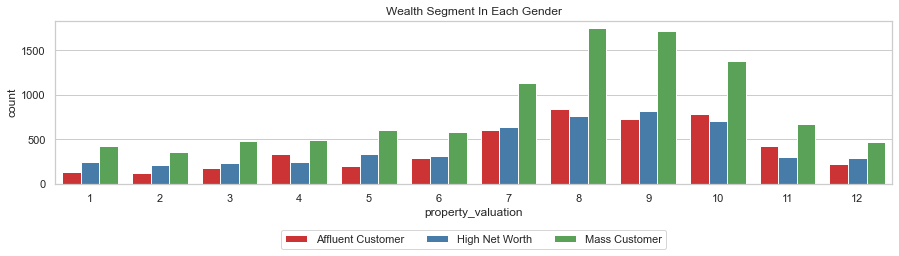

In [896]:
# zooming in at the most common wealth segment for each property valuation
wealth_segment_property_valuation = df.groupby(by=['property_valuation','wealth_segment']).agg({'customer_id':'count'}).reset_index()
wealth_segment_property_valuation.rename(columns={'customer_id':'count'}, inplace=True)


# plot
plt.figure(figsize=(15,3))
sns.barplot(x='property_valuation', y='count', data=wealth_segment_property_valuation, hue='wealth_segment', palette='Set1')
plt.title('Wealth Segment In Each Gender')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=14)
plt.show()

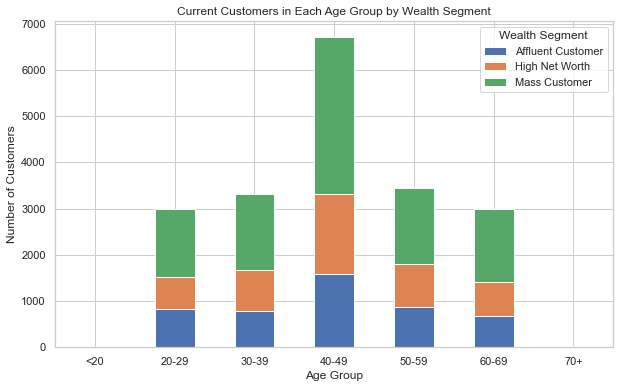

In [897]:
#  wealth segment by age group
age_bins = [0, 20, 30, 40, 50, 60, 70, 120]
age_labels = ['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

# Assign each customer to an age group
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

# Count the number of customers in each age group and wealth segment
age_wealth_counts = df.groupby(['age_group', 'wealth_segment'])['customer_id'].count().unstack()

# Plot the stacked bar chart
ax = age_wealth_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.title('Current Customers in Each Age Group by Wealth Segment')
plt.xticks(np.arange(len(age_labels)), age_labels, rotation=0)
plt.legend(title='Wealth Segment')

plt.show()

In [898]:
age_wealth_counts


wealth_segment,Affluent Customer,High Net Worth,Mass Customer
age_group,,,
<20,0,0,0
20-29,834,690,1473
30-39,779,882,1662
40-49,1575,1736,3405
50-59,876,916,1657
60-69,678,734,1578
70+,15,7,8


##### Job Industry Categories

In [899]:
# job industry 
job_industry = df.groupby('job_industry_category').agg({'customer_id':'nunique'}).reset_index()
job_industry.rename(columns={'customer_id':'count'}, inplace=True)
job_industry.sort_values(by='count', ascending=False, inplace=True)
job_industry

,job_industry_category,count
5,Manufacturing,703
2,Financial Services,686
3,Health,531
7,Retail,304
6,Property,230
4,IT,188
1,Entertainment,123
0,Argiculture,100
8,Telecommunications,63


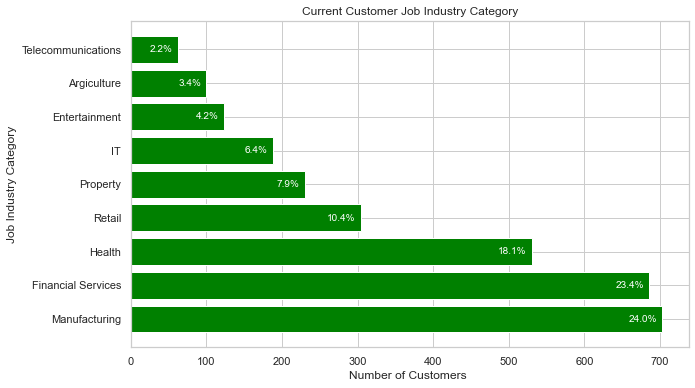

In [900]:
# plot
job_industry['percentage'] = (job_industry['count'] / job_industry['count'].sum()) * 100

# plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(job_industry['job_industry_category'], job_industry['count'], align='center', color='green')


# Add percentage labels to each bar
for bar, percentage in zip(bars, job_industry['percentage']):
    width = bar.get_width()
    label_x_pos = width - (0.01 * np.max(job_industry['count']))
    ax.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'{percentage:.1f}%', va='center', ha='right', color='white', fontsize=10)


plt.title('Current Customer Job Industry Category')
plt.xlabel('Number of Customers ')
ax.set_ylabel('Job Industry Category')
plt.show()

##### Tenure

In [901]:
tenure_stats = df['tenure'].describe()
print("Tenure statistics:\n", tenure_stats)

Tenure statistics:
 count    19514.000000
mean        10.683868
std          5.675002
min          1.000000
25%          6.000000
50%         11.000000
75%         15.000000
max         22.000000
Name: tenure, dtype: float64


In [903]:
# Calculate the number of customers in each tenure group
tenure_groups = df['tenure'].value_counts().sort_index()
print("\nNumber of customers in each tenure group:\n", tenure_groups)


Number of customers in each tenure group:
 1.0      869
2.0      736
3.0      819
4.0      929
5.0     1096
6.0      945
7.0     1190
8.0     1032
9.0      995
10.0     985
11.0    1088
12.0    1060
13.0     973
14.0    1019
15.0     908
16.0    1067
17.0     985
18.0     959
19.0     837
20.0     492
21.0     275
22.0     255
Name: tenure, dtype: int64


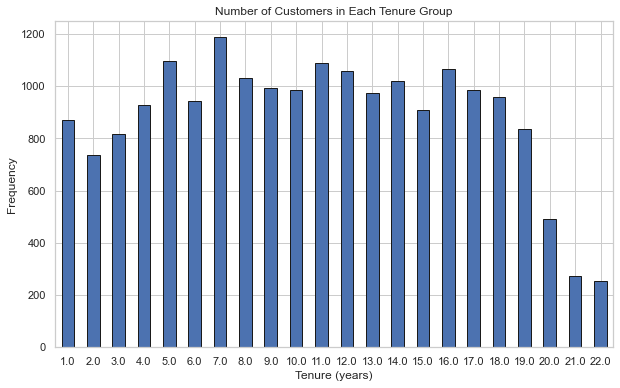

In [904]:
# Plot the number of customers in each tenure group
plt.figure(figsize=(10, 6))
tenure_groups.plot(kind='bar', edgecolor='k')
plt.title("Number of Customers in Each Tenure Group")
plt.xlabel("Tenure (years)")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

##### Car ownership

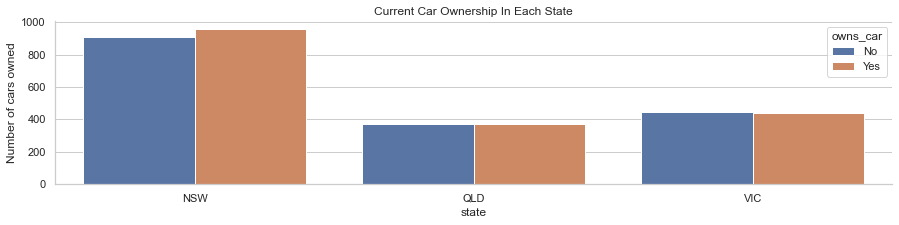

In [905]:
# car ownership in each state 
car_ownership_state = df.groupby(by=['state','owns_car']).agg({'customer_id':'nunique'}).reset_index()
car_ownership_state.rename(columns={'customer_id':'count'}, inplace=True)

# plot
plt.figure(figsize=(15,3))
ax = sns.barplot(x='state', y='count', data=car_ownership_state, hue='owns_car')

plt.title('Current Car Ownership In Each State')  
plt.ylabel("Number of cars owned")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


In [906]:
car_ownership_state = car_ownership_state.pivot(index='state', columns='owns_car', values='count')

In [907]:
car_ownership_state['total'] = car_ownership_state['Yes'] + car_ownership_state['No']
car_ownership_state['percentage'] = (car_ownership_state['Yes'] / car_ownership_state['total']) * 100
car_ownership_state

owns_car,No,Yes,total,percentage
state,,,,
NSW,907,958,1865,51.367292
QLD,372,371,743,49.932705
VIC,443,437,880,49.659091


#### Customer Loyalty and Churn

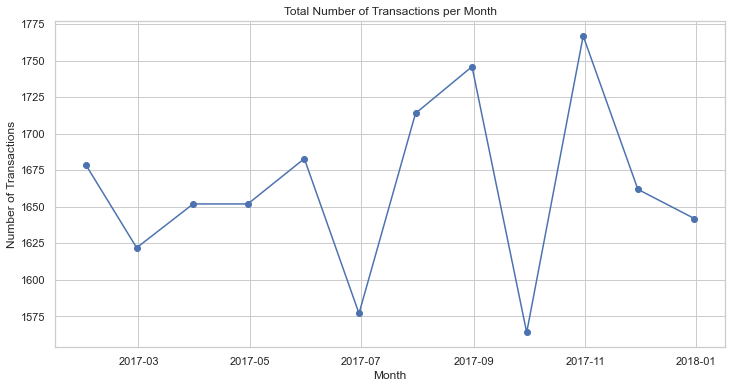

In [909]:
# Unfortunately, based on the columns provided in the dataset, there is no direct information about customer churn, such as a 'churned' column or an 'end_date' for the customer relationship. 
# To calculate the churn rate, I'd need additional information would identify customers who have stopped purchasing over a given period.
# However, 'transaction_date' can provide a sense of the overall engagement. This may provide insights about potential churn, but it won't be an exact churn rate.


transactions_by_month = df.resample('M', on='transaction_date').size().reset_index(name='transaction_count')

# Plot the total number of transactions per month
plt.figure(figsize=(12, 6))
plt.plot(transactions_by_month['transaction_date'], transactions_by_month['transaction_count'], marker='o')
plt.title("Total Number of Transactions per Month")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.show()

The drop rate could be due to churning or seasonality 

##### Customer Value (CLV)

In [910]:
# formula = Customer Value = (Average Purchase Value x Average Number of Purchases)
customer_value = avg_purchase_value * purchase_frequency
print(f"Estimated Customer  Value: ${customer_value:.2f}")

Estimated Customer  Value: $6338.36


In [911]:
# average customer lifespan
# assumptions : the average tenure as a proxy for lifespan 
average_tenure = df['tenure'].mean()
print(f"Estimated Average Customer Lifespan: {average_tenure:.2f}")


Estimated Average Customer Lifespan: 10.68


In [912]:
# formula for clv : average purchase value * purchase frequency * customer lifespan, simplified version : customer value * customer lifespan
clv = customer_value * average_tenure

print(f"Estimated Customer Lifetime Value: ${clv:.2f}")

Estimated Customer Lifetime Value: $67718.25


### New Potential Customers 


In [352]:
new_customer.head()

,Unnamed: 0,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,Rank,Value,age
0,0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,No,Yes,14,45 Shopko Center,4500,QLD,Australia,6,1,1.718750,66.0
1,1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,No,No,16,14 Mccormick Park,2113,NSW,Australia,11,1,1.718750,53.0
2,2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,No,No,10,5 Colorado Crossing,3505,VIC,Australia,5,1,1.718750,49.0
3,3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,No,Yes,5,207 Annamark Plaza,4814,QLD,Australia,1,4,1.703125,44.0
4,4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,No,No,19,115 Montana Place,2093,NSW,Australia,9,4,1.703125,58.0


In [353]:
new_customer.shape

(1000, 20)

In [354]:
new_customer.describe()

,Unnamed: 0,past_3_years_bike_related_purchases,tenure,postcode,property_valuation,Rank,Value,age
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,983.000000
mean,499.500000,49.836000,11.388000,3019.227000,7.397000,498.819000,0.881714,52.206511
std,288.819436,27.796686,5.037145,848.895767,2.758804,288.810997,0.293525,17.074268
min,0.000000,0.000000,0.000000,2000.000000,1.000000,1.000000,0.340000,21.000000
25%,249.750000,26.750000,7.000000,2209.000000,6.000000,250.000000,0.649531,40.000000
50%,499.500000,51.000000,11.000000,2800.000000,8.000000,500.000000,0.860000,51.000000
75%,749.250000,72.000000,15.000000,3845.500000,9.000000,750.250000,1.075000,66.000000
max,999.000000,99.000000,22.000000,4879.000000,12.000000,1000.000000,1.718750,85.000000


In [355]:
new_customer.columns

Index(['Unnamed: 0', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'Rank', 'Value', 'age'],
      dtype='object')

#### High Level Analysis 

##### Age

In [356]:
new_customer.age.describe()

count    983.000000
mean      52.206511
std       17.074268
min       21.000000
25%       40.000000
50%       51.000000
75%       66.000000
max       85.000000
Name: age, dtype: float64

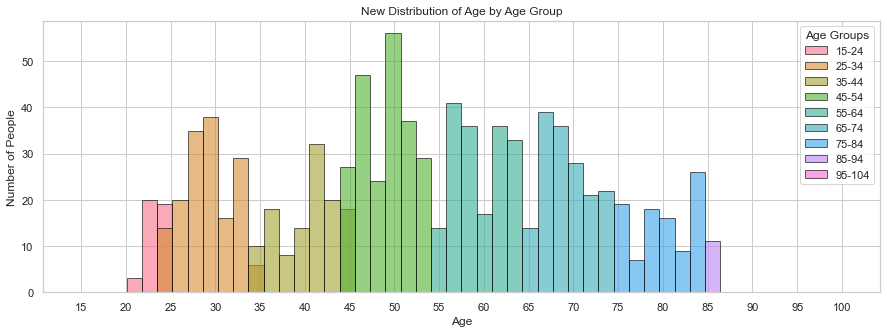

In [357]:
# Define age groups and color palette
age_groups = [(15, 24), (25, 34), (35, 44), (45, 54), (55, 64), (65, 74), (75, 84), (85, 94), (95, 104)]
colors = sns.color_palette("husl", len(age_groups))

plt.figure(figsize=(15,5))

# Loop through age groups, plot histograms, and create legends
for age_range, color in zip(age_groups, colors):
    mask = (new_customer.age >= age_range[0]) & (new_customer.age <= age_range[1])
    new_customer.loc[mask, 'age'].hist(alpha=0.6, bins=50, range=(15,100), color=color, edgecolor='black', label=f"{age_range[0]}-{age_range[1]}")

plt.xticks(range(15, 101, 5))
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.title('New Distribution of Age by Age Group')
plt.legend(title='Age Groups')
plt.show()


##### Geographic Distribution

In [358]:
# state 
state_ratio = new_customer.groupby('state').agg({'first_name':'count'}).reset_index()
state_ratio = state_ratio.rename(columns={'first_name':'count'})

state_ratio


,state,count
0,NSW,506
1,QLD,228
2,VIC,266


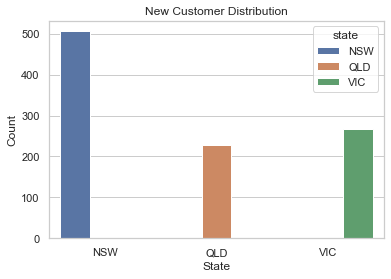

In [359]:
p = sns.barplot(x='state', y='count', hue='state', data=state_ratio)
plt.title('New Customer Distribution')
plt.xlabel('State')
plt.ylabel('Count')
plt.show()

In [360]:
# postcode 
postcode_data = new_customer[['postcode']]

# The scaler transforms the features by subtracting the mean and dividing by the standard deviation. 
# This is done in order to standardize the scale of each feature and bring them to the same level of importance.
scaler = StandardScaler()
postcode_data_scaled = scaler.fit_transform(postcode_data)

# cluster data
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(postcode_data_scaled)

# add cluster labels to dataframe
new_customer['postcode_cluster'] = kmeans.labels_

# Group the DataFrame by 'postcode_cluster' and find the min and max postal code for each cluster
postcode_ranges = new_customer.groupby('postcode_cluster')['postcode'].agg(['min', 'max']).reset_index()
print('Summary :\n ' ,postcode_ranges.head(), '\n') 

Summary :
     postcode_cluster   min   max
0                 0  2390  2880
1                 1  3620  4285
2                 2  3000  3585
3                 3  4300  4879
4                 4  2000  2380 



In [361]:
# property valuation
print("Statistics:\n" , new_customer['property_valuation'].describe())

Statistics:
 count    1000.000000
mean        7.397000
std         2.758804
min         1.000000
25%         6.000000
50%         8.000000
75%         9.000000
max        12.000000
Name: property_valuation, dtype: float64


##### Wealth Segmentation 


In [362]:
wealth_segment = new_customer.groupby('wealth_segment').agg({'first_name':'count'}).reset_index()
wealth_segment.rename(columns={'first_name':'count'}, inplace=True)
wealth_segment.sort_values(by='count', ascending=False, inplace=True)
wealth_segment

,wealth_segment,count
2,Mass Customer,508
1,High Net Worth,251
0,Affluent Customer,241


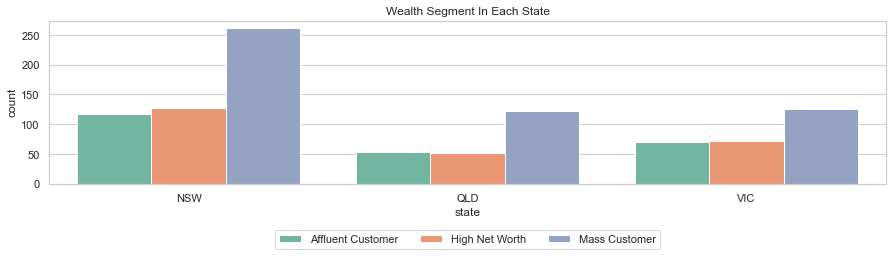

In [363]:
# zooming in at the most common wealth segment in each state
wealth_segment_state = new_customer.groupby(by=['state','wealth_segment']).agg({'first_name':'count'}).reset_index()
wealth_segment_state.rename(columns={'first_name':'count'}, inplace=True)

# plot
plt.figure(figsize=(15,3))
sns.barplot(x='state', y='count', data=wealth_segment_state, hue='wealth_segment', palette='Set2')
plt.title('Wealth Segment In Each State')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=14)
plt.show()

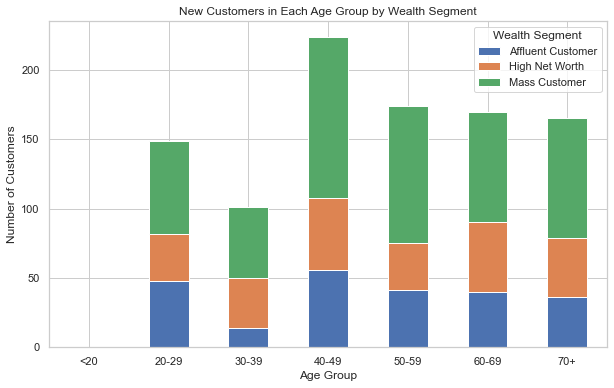

In [364]:
# wealth segment by age group

age_bins = [0, 20, 30, 40, 50, 60, 70, 120]
age_labels = ['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

# Assign each customer to an age group
new_customer['age_group'] = pd.cut(new_customer['age'], bins=age_bins, labels=age_labels)

# Count the number of customers in each age group and wealth segment
age_wealth_counts = new_customer.groupby(['age_group', 'wealth_segment'])['first_name'].count().unstack()

# Plot the stacked bar chart
ax = age_wealth_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.title('New Customers in Each Age Group by Wealth Segment')
plt.xticks(np.arange(len(age_labels)), age_labels, rotation=0)
plt.legend(title='Wealth Segment')

plt.show()

In [365]:
age_wealth_counts

wealth_segment,Affluent Customer,High Net Worth,Mass Customer
age_group,,,
<20,0,0,0
20-29,48,34,67
30-39,14,36,51
40-49,56,52,116
50-59,41,34,99
60-69,40,50,80
70+,36,43,86


##### Job Industry Categories 

In [366]:
# job industry 
job_industry = new_customer.groupby('job_industry_category').agg({'first_name':'count'}).reset_index()
job_industry.rename(columns={'first_name':'count'}, inplace=True)
job_industry.sort_values(by='count', ascending=False, inplace=True)
job_industry

,job_industry_category,count
2,Financial Services,203
5,Manufacturing,199
3,Health,152
7,Retail,78
6,Property,64
4,IT,51
1,Entertainment,37
0,Argiculture,26
8,Telecommunications,25


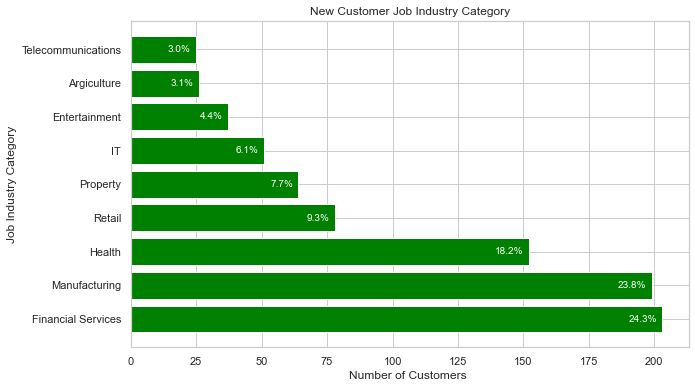

In [367]:
# plot
job_industry['percentage'] = (job_industry['count'] / job_industry['count'].sum()) * 100

# plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(job_industry['job_industry_category'], job_industry['count'], align='center', color='green')

# Add percentage labels to each bar
for bar, percentage in zip(bars, job_industry['percentage']):
    width = bar.get_width()
    label_x_pos = width - (0.01 * np.max(job_industry['count']))
    ax.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'{percentage:.1f}%', va='center', ha='right', color='white', fontsize=10)

plt.title('New Customer Job Industry Category')
plt.xlabel('Number of Customers ')
ax.set_ylabel('Job Industry Category')

plt.show()

In [368]:
new_customer

,Unnamed: 0,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,address,postcode,state,country,property_valuation,Rank,Value,age,postcode_cluster,age_group
0,0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,No,...,45 Shopko Center,4500,QLD,Australia,6,1,1.718750,66.0,3,60-69
1,1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,No,...,14 Mccormick Park,2113,NSW,Australia,11,1,1.718750,53.0,4,50-59
2,2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,No,...,5 Colorado Crossing,3505,VIC,Australia,5,1,1.718750,49.0,2,40-49
3,3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,No,...,207 Annamark Plaza,4814,QLD,Australia,1,4,1.703125,44.0,3,40-49
4,4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,No,...,115 Montana Place,2093,NSW,Australia,9,4,1.703125,58.0,4,50-59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,Ferdinand,Romanetti,Male,60,1959-10-07,Paralegal,Financial Services,Affluent Customer,No,...,2 Sloan Way,2200,NSW,Australia,7,996,0.374000,64.0,4,60-69
996,996,Burk,Wortley,Male,22,2001-10-17,Senior Sales Associate,Health,Mass Customer,No,...,04 Union Crossing,2196,NSW,Australia,10,997,0.357000,22.0,4,20-29
997,997,Melloney,Temby,Female,17,1954-10-05,Budget/Accounting Analyst IV,Financial Services,Affluent Customer,No,...,33475 Fair Oaks Junction,4702,QLD,Australia,2,997,0.357000,69.0,3,60-69
998,998,Dickie,Cubbini,Male,30,1952-12-17,Financial Advisor,Financial Services,Mass Customer,No,...,57666 Victoria Way,4215,QLD,Australia,2,997,0.357000,71.0,1,70+


##### Car ownership 

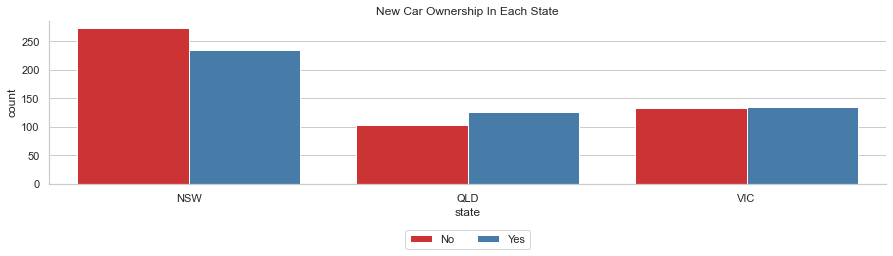

In [369]:
# car ownership in each state 
car_ownership_state = new_customer.groupby(by=['state','owns_car']).agg({'first_name':'count'}).reset_index()
car_ownership_state.rename(columns={'first_name':'count'}, inplace=True)

# Calculate percentage
total_customers_by_state = new_customer.groupby(by=['state']).agg({'first_name': 'count'}).reset_index()
total_customers_by_state.rename(columns={'first_name': 'total_count'}, inplace=True)

car_ownership_state = car_ownership_state.merge(total_customers_by_state, on='state', how='left')
car_ownership_state['percentage'] = (car_ownership_state['count'] / car_ownership_state['total_count']) * 100

# Plot
plt.figure(figsize=(15, 3))
ax = sns.barplot(x='state', y='count', data=car_ownership_state, hue='owns_car', palette='Set1')
plt.title('New Car Ownership In Each State')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [370]:
car_ownership_state

,state,owns_car,count,total_count,percentage
0,NSW,No,272,506,53.754941
1,NSW,Yes,234,506,46.245059
2,QLD,No,103,228,45.175439
3,QLD,Yes,125,228,54.824561
4,VIC,No,132,266,49.624060
5,VIC,Yes,134,266,50.375940


## Area To Target New Customers

In [612]:
# extract high value customers 
high_value = rfm[rfm['RFM_segment'] == 'High Value']
high_value = high_value.reset_index()

# create a new dataframe with the columns we need
high_value_customers = df[df.customer_id.isin(high_value['customer_id'])]

In [613]:
high_value_customers.shape

(5707, 37)

In [615]:
high_value_customers.columns

Index(['Unnamed: 0trans_', 'transaction_id', 'product_id', 'customer_id',
       'transaction_date', 'online_order', 'order_status', 'brand',
       'product_line', 'product_class', 'product_size', 'list_price',
       'standard_cost', 'product_first_sold_date', 'profit', 'Unnamed: 0demo_',
       'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'default', 'owns_car', 'tenure', 'age', 'Unnamed: 0', 'address',
       'postcode', 'state', 'country', 'property_valuation',
       'postcode_cluster', 'age_group'],
      dtype='object')

In [688]:
# high value customers postcodes

high_value_postcode = high_value_customers.postcode.value_counts().reset_index()

In [692]:
high_value_postcode.agg(['min','max'])

,index,postcode
min,2007,7
max,4883,53


In [782]:
# high value job_industry_category
high_value_job_industry = high_value_customers.job_industry_category.value_counts()
high_value_job_industry = list(high_value_job_industry.index)
high_value_job_industry

['Financial Services',
 'Manufacturing',
 'Health',
 'Retail',
 'Property',
 'IT',
 'Entertainment',
 'Argiculture',
 'Telecommunications']

In [783]:
# brand
# product_line
# product_class
# past_3_years_bike_related_purchases

In [784]:
# high value brand
high_value_purchases = high_value_customers.past_3_years_bike_related_purchases.value_counts()
high_value_purchases = list(high_value_purchases.index)

In [790]:
# high value brand
high_value_age = high_value_customers.age.value_counts()
high_value_age = list(high_value_age.index)

In [792]:
condition_new = (
    new_customer['postcode'].between(2007, 4883) &
    new_customer['job_industry_category'].isin(high_value_job_industry) &
    new_customer['past_3_years_bike_related_purchases'].isin(high_value_purchases) &
    new_customer['age'].isin(high_value_age)
)


In [811]:
# top 10 customers to target
targeted_customers = new_customer[conditon_new]
targeted_customers.head(10)

,Unnamed: 0,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,address,postcode,state,country,property_valuation,Rank,Value,age,postcode_cluster,age_group
0,0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,No,...,45 Shopko Center,4500,QLD,Australia,6,1,1.718750,66.0,3,60-69
1,1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,No,...,14 Mccormick Park,2113,NSW,Australia,11,1,1.718750,53.0,4,50-59
2,2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,No,...,5 Colorado Crossing,3505,VIC,Australia,5,1,1.718750,49.0,2,40-49
3,3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,No,...,207 Annamark Plaza,4814,QLD,Australia,1,4,1.703125,44.0,3,40-49
4,4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,No,...,115 Montana Place,2093,NSW,Australia,9,4,1.703125,58.0,4,50-59
5,5,Druci,Brandli,Female,39,1951-04-29,Assistant Media Planner,Entertainment,High Net Worth,No,...,89105 Pearson Terrace,4075,QLD,Australia,7,6,1.671875,72.0,1,70+
6,6,Rutledge,Hallt,Male,23,1976-10-06,Compensation Analyst,Financial Services,Mass Customer,No,...,7 Nevada Crossing,2620,NSW,Australia,7,6,1.671875,47.0,0,40-49
7,7,Nancie,Vian,Female,74,1972-12-27,Human Resources Assistant II,Retail,Mass Customer,No,...,85 Carioca Point,4814,QLD,Australia,5,8,1.656250,51.0,3,50-59
8,8,Duff,Karlowicz,Male,50,1972-04-28,Speech Pathologist,Manufacturing,Mass Customer,No,...,717 West Drive,2200,NSW,Australia,10,8,1.656250,51.0,4,50-59
9,9,Barthel,Docket,Male,72,1985-08-02,Accounting Assistant IV,IT,Mass Customer,No,...,80 Scofield Junction,4151,QLD,Australia,5,10,1.640625,38.0,1,30-39


In [813]:
targeted_customers.to_csv(PATH + 'targeted_customers.csv', index=False)